## **<center>Spam comment filter using Naive Bayes Classifier**



In this notebook, I will be creating a spam filter using multinomial naive bayes algorithm without sci-kit learn, to filter out spam comments from Youtube videos.
We have data of labelled youtube comments in five seperate files. So we'll train our model with four of them and use the fifth file for prediction and testing for accuracy. 
The data set used in this notebook can be found [here](https://www.kaggle.com/prashant111/youtube-spam-collection)

In [ ]:
all_files=["Youtube01-Psy.csv","Youtube02-KatyPerry.csv","Youtube03-LMFAO.csv","Youtube04-Eminem.csv"]

In [ ]:
list_=[]
import pandas as pd
for file_ in all_files:
    frame = pd.read_csv(("../input/images/"+file_),index_col=None, header=0)
    list_.append(frame)

# concatenate all dfs into one
df = pd.concat(list_, ignore_index=True)

In [ ]:
df

# Data Cleaning

Since, our aim is to classify comments as spam or not spam, we can drop the first three columns of the dataframe. Upon inspection of data, we can see that there are few tags, links and parsing errors that we need to clean up before we can create our classification model.

In [ ]:
df.drop(columns=["COMMENT_ID","AUTHOR","DATE"],inplace=True)

In [ ]:
df["CONTENT"][700]

In [ ]:
import html
df["CONTENT"]=df["CONTENT"].apply(html.unescape)
df["CONTENT"]=df["CONTENT"].str.replace("\ufeff","")

In [ ]:
df["CONTENT"][700]

To improve efficiency of our model, let's replace all link 
tags with a common word so that our algorithm treats all links as a single feature in our classification. Since all a-tags will have hyperlinks, lets replace them with a single word "htmllink".

In [ ]:
df["CONTENT"]=df["CONTENT"].str.replace("(<a.+>)","htmllink")

Now lets inspect all other tags and remove them as they are not relevant to our analysis. 

In [ ]:
df[df["CONTENT"].str.contains("<.+>")]["CONTENT"]

In [ ]:
df["CONTENT"]=df["CONTENT"].str.replace("<.+>","")

In [ ]:
df["CONTENT"]=df["CONTENT"].str.replace("\'","")

In [ ]:
df["CONTENT"]=df["CONTENT"].str.lower()

In [ ]:
df[df["CONTENT"].str.contains("\.com|watch\?")]

There are still few rows with links. Let's replace them too with "htmllink" and then remove all non-alpha numerical characters.

In [ ]:
df["CONTENT"][1573]

In [ ]:
df["CONTENT"]=df["CONTENT"].str.replace(r"\S*\.com\S*|\S*watch\?\S*","htmllink")

In [ ]:
df["CONTENT"]=df["CONTENT"].str.replace("\W"," ")

In [ ]:
df["CONTENT"][1573]

In [ ]:
df["CONTENT"][14]

# 2. Model Creation

In [ ]:
df["CLASS"].value_counts(normalize=True)

We need to find the two probabilities inorder to find out if a comment is spam or not:

*  Probability that a comment is spam, given the words in the comment
*   Probability that a comment is not spam, given the words in the comment

To find these probabilities, we can use the formula shown below



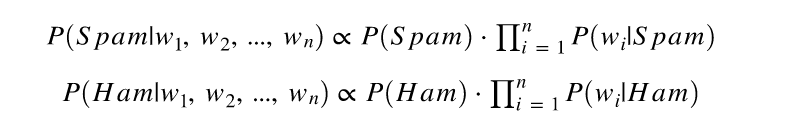

Inorder to calculate the conditional probabilities of words (given its a spam or not), we can use the formula shown below:
* Note that we will be using Laplace smoothing (alpha=1) for sample correction. We are using a correction to avoid a probability value to become zero just because probability of one of the words in the comment is zero (Since we perform multiplication). Check [this](https://medium.com/syncedreview/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation-4f5271768ebf) blog out for a better explaination.

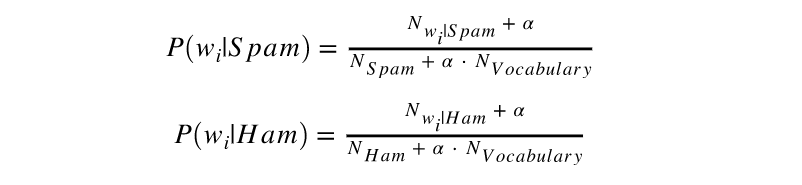

Now let's get the unique words and perform the required calculations

In [ ]:
vocab=[]
for comment in df["CONTENT"]:
    for word in comment.split():
        vocab.append(word)

In [ ]:
vocabulary=list(set(vocab))
len(vocabulary)

In [ ]:
# Create a column for each of the unique word in our vocabulary inorder to get the count of words 
for word in vocabulary:
    df[word]=0

In [ ]:
df.head()

In [ ]:
# looping through data frame and counting words 
for index,value in enumerate(df["CONTENT"]):
  for l in value.split():
    df[l][index]+=1

In [ ]:
df.head()

In [ ]:
#Total number of words in each class
df.groupby("CLASS").sum().sum(axis=1)

In [ ]:
# Assign variables to all values required in calculation
p_ham=0.47604
p_spam=0.52396
n_spam=df[df["CLASS"]==1].drop(columns=["CONTENT","CLASS"]).sum().sum()
n_ham=df[df["CLASS"]==0].drop(columns=["CONTENT","CLASS"]).sum().sum()
n_vocabulary=len(vocabulary)

In [ ]:
# Slicing dataframe for each class
df_sspam=df[df["CLASS"]==1]
df_hham=df[df["CLASS"]==0]

Let's create dictionaries to store probabilities of each word in dataframe given its a spam and not spam, so that we can reference values when required

In [ ]:
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}
for word in vocabulary:
    n_word_given_spam = df_sspam[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + 1) / (n_spam + 1*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    n_word_given_ham = df_hham[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + 1) / (n_ham + 1*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

# 3. Model Testing

Let's create a function to clean a comment as we did before, calculate probabilities and return the predicted class of that comment

In [ ]:
def classifier(string):
    message=html.unescape(string)
    message=string.replace("\ufeff","")
    message=string.replace("(<a.+>)","htmllink")
    message=string.replace("\'|<.+>","")
    message=string.replace("\S*\.com\S*|\S*watch\?\S*","htmllink")
    message=string.replace("\W"," ").lower()
    p_string_s=1
    p_string_h=1
    for word in message.split():
        if word in parameters_spam:
            p_string_s*=parameters_spam[word]
            p_string_h*=parameters_ham[word]
    if (p_string_s*p_spam)>(p_string_h*p_ham):
        return(1)
    elif (p_string_s*p_spam)<(p_string_h*p_ham):
        return(0)
    else:
        return(-1)

In [ ]:
# Reading the dataframe for testing model
df_shakira=pd.read_csv("../input/images/Youtube05-Shakira.csv")

In [ ]:
df_shakira.head()

In [ ]:
df_shakira["Pred_Class"]=df_shakira["CONTENT"].apply(classifier)

In [ ]:
correct_predictions=0
total_rows=0
for row in df_shakira.iterrows():
    row=row[1]
    total_rows+=1
    if row["CLASS"]==row["Pred_Class"]:
        correct_predictions+=1
accuracy=correct_predictions/total_rows
print("accuracy=",accuracy)


## **Conclusion**

Our model classified ~85% of the comments correctly. Considering the simplicity of this algorithm, it is a really useful classification model, which is often used in Natural Language processing (NLP) problems

However, one of the major drawbacks of naive-bayes classifier is that it does not consider the relationship between features. 

Let's try to classify some commonly seen comments on YouTube using our model (1 - Spam, 0 - Not Spam)

In [ ]:
classifier("This song gives me goosebumps!!")


In [ ]:
classifier("Please subscribe to my channel as I'm approaching 1M subscribers")

In [ ]:
classifier("If you want to be a mastercoder, consider buying my course for 50% off at www.buymycourse.com")